In [1]:
import warnings

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.model_selection import train_test_split, RandomizedSearchCV, KFold
from imblearn.over_sampling import SMOTE
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score

warnings.filterwarnings('ignore')

In [2]:
bank_data = pd.read_csv("../b. Datasets/Bank Churn/BankChurn.csv")

In [3]:
display(bank_data.head(2))
display(bank_data.tail(2))

,CreditScore,Geography,Gender,Age,NumOfYrsWithBank,Balance,NumOfProducts,HasCrCard,Closed_Acc
0,619,France,Female,42,2,0.00,1,1,1
1,608,Spain,Female,41,1,83807.86,1,0,0


,CreditScore,Geography,Gender,Age,NumOfYrsWithBank,Balance,NumOfProducts,HasCrCard,Closed_Acc
9918,772,Germany,Male,42,3,75075.31,2,1,1
9919,792,France,Female,28,4,130142.79,1,1,0


In [4]:
bank_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9920 entries, 0 to 9919
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   CreditScore       9920 non-null   int64  
 1   Geography         9920 non-null   object 
 2   Gender            9920 non-null   object 
 3   Age               9920 non-null   int64  
 4   NumOfYrsWithBank  9920 non-null   int64  
 5   Balance           9920 non-null   float64
 6   NumOfProducts     9920 non-null   int64  
 7   HasCrCard         9920 non-null   int64  
 8   Closed_Acc        9920 non-null   int64  
dtypes: float64(1), int64(6), object(2)
memory usage: 697.6+ KB


In [5]:
bank_data.isna().sum()

CreditScore         0
Geography           0
Gender              0
Age                 0
NumOfYrsWithBank    0
Balance             0
NumOfProducts       0
HasCrCard           0
Closed_Acc          0
dtype: int64

In [6]:
bank_data.describe().T

,count,mean,std,min,25%,50%,75%,max
CreditScore,9920.0,650.804536,96.119083,382.0,584.0,652.00,718.00,850.00
Age,9920.0,38.768347,10.129247,18.0,32.0,37.00,44.00,75.00
NumOfYrsWithBank,9920.0,5.006351,2.890735,0.0,2.0,5.00,7.00,10.00
Balance,9920.0,76477.336143,62407.729207,0.0,0.0,97221.52,127644.24,250898.09
NumOfProducts,9920.0,1.529940,0.581073,1.0,1.0,1.00,2.00,4.00
HasCrCard,9920.0,0.705847,0.455684,0.0,0.0,1.00,1.00,1.00
Closed_Acc,9920.0,0.203831,0.402865,0.0,0.0,0.00,0.00,1.00


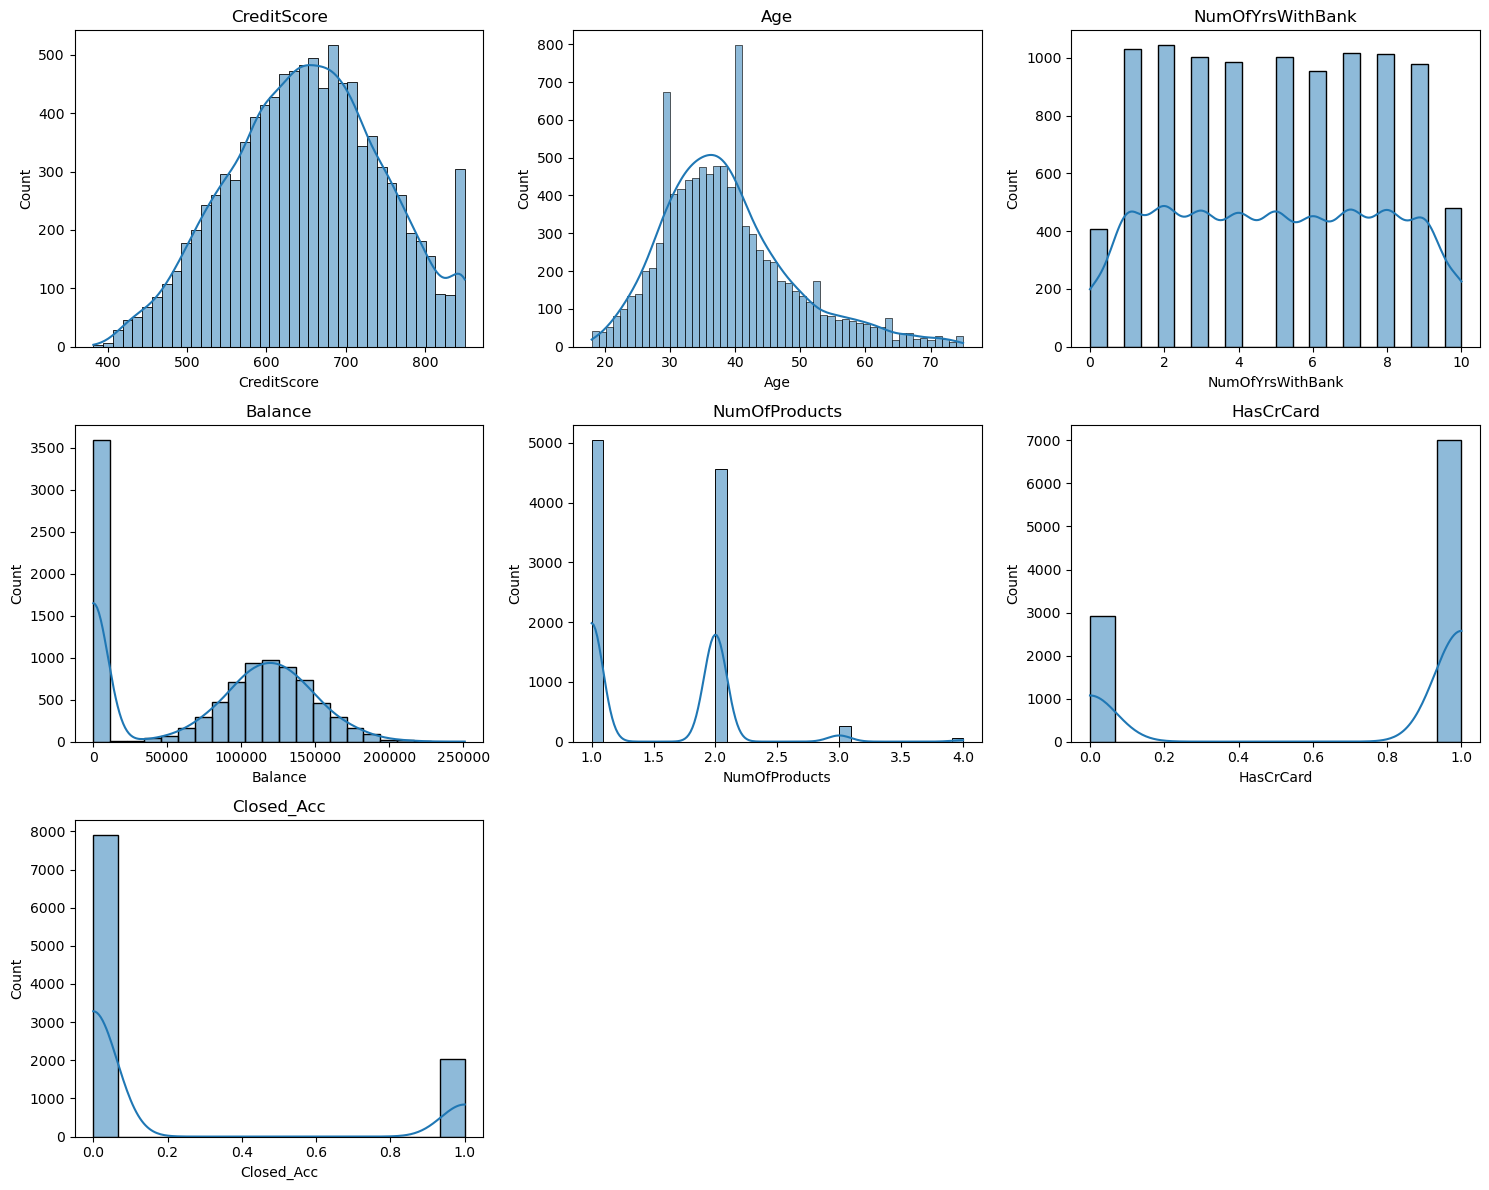

In [7]:
numerical_features = bank_data.select_dtypes(include='number').columns
num_cols = 3
num_rows = (len(numerical_features) + num_cols - 1) // num_cols

fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, num_rows * 4))
axes = axes.flatten()

for index, column in enumerate(numerical_features):
    sns.histplot(data=bank_data, x=column, ax=axes[index], kde=True)
    axes[index].set_title(column)

for j in range(index + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

In [8]:
bank_data.select_dtypes('number').skew()

CreditScore        -0.044588
Age                 0.891266
NumOfYrsWithBank    0.014484
Balance            -0.140694
NumOfProducts       0.742244
HasCrCard          -0.903645
Closed_Acc          1.470613
dtype: float64

In [9]:
categorical_data = bank_data.select_dtypes('object')
features_not_to_be_altered = bank_data[['Closed_Acc', 'HasCrCard']]
bank_data = bank_data.drop(['Closed_Acc', 'Geography', 'Gender', 'HasCrCard'], axis=1)
bank_data_features = bank_data.columns

yeo_johnson = PowerTransformer(method='yeo-johnson')
bank_data = yeo_johnson.fit_transform(bank_data)
bank_data = pd.DataFrame(bank_data, columns=bank_data_features)

bank_data = bank_data.reset_index().drop('index', axis=1)
categorical_data = categorical_data.reset_index().drop('index', axis=1)
features_not_to_be_altered = features_not_to_be_altered.reset_index().drop('index', axis=1)
bank_data = pd.concat([bank_data, categorical_data, features_not_to_be_altered], axis=1)

bank_data.select_dtypes('number').skew()

CreditScore        -0.026101
Age                -0.000626
NumOfYrsWithBank   -0.174911
Balance            -0.555342
NumOfProducts       0.150790
Closed_Acc          1.470613
HasCrCard          -0.903645
dtype: float64

In [10]:
bank_data.head(2)

,CreditScore,Age,NumOfYrsWithBank,Balance,NumOfProducts,Geography,Gender,Closed_Acc,HasCrCard
0,-0.334698,0.462791,-1.025177,-1.323919,-0.968478,France,Female,1,1
1,-0.448856,0.368942,-1.447166,0.632382,-0.968478,Spain,Female,0,0


In [11]:
bank_data.select_dtypes('object').nunique()

Geography    3
Gender       2
dtype: int64

In [12]:
bank_data = pd.get_dummies(bank_data, columns=['Geography', 'Gender'])
bank_data.head(2)

,CreditScore,Age,NumOfYrsWithBank,Balance,NumOfProducts,Closed_Acc,HasCrCard,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male
0,-0.334698,0.462791,-1.025177,-1.323919,-0.968478,1,1,True,False,False,True,False
1,-0.448856,0.368942,-1.447166,0.632382,-0.968478,0,0,False,False,True,True,False


In [13]:
X = bank_data.drop(labels='Closed_Acc', axis=1)
y = bank_data['Closed_Acc']

display(X.head(2))
display(y.head(2))

,CreditScore,Age,NumOfYrsWithBank,Balance,NumOfProducts,HasCrCard,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male
0,-0.334698,0.462791,-1.025177,-1.323919,-0.968478,1,True,False,False,True,False
1,-0.448856,0.368942,-1.447166,0.632382,-0.968478,0,False,False,True,True,False


0    1
1    0
Name: Closed_Acc, dtype: int64

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

smote = SMOTE(sampling_strategy='minority', random_state=0)
X_train, y_train = smote.fit_resample(X_train, y_train)

In [15]:
standard_scaler = StandardScaler()
X_train_scaled = standard_scaler.fit_transform(X_train)
X_test_scaled = standard_scaler.transform(X_test)

In [16]:
knn = KNeighborsClassifier()

param_grid = {
    'n_neighbors': range(4, 20),
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski'],
    'p': [1, 2],
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
    'leaf_size': [10, 20, 30, 40, 50]
}

k_fold_cross_val = KFold(n_splits=5, shuffle=True, random_state=0)

random_search = RandomizedSearchCV(estimator=knn, 
                                   param_distributions=param_grid, 
                                   n_iter=10, 
                                   cv=k_fold_cross_val,
                                   scoring='accuracy', 
                                   random_state=0)

random_search.fit(X_train_scaled, y_train)

best_params = random_search.best_params_
best_knn = random_search.best_estimator_

print("Best Parameters:", best_params)

Best Parameters: {'weights': 'distance', 'p': 2, 'n_neighbors': 4, 'metric': 'manhattan', 'leaf_size': 50, 'algorithm': 'auto'}


In [17]:
y_train_pred = best_knn.predict(X_train_scaled)
y_test_pred = best_knn.predict(X_test_scaled)

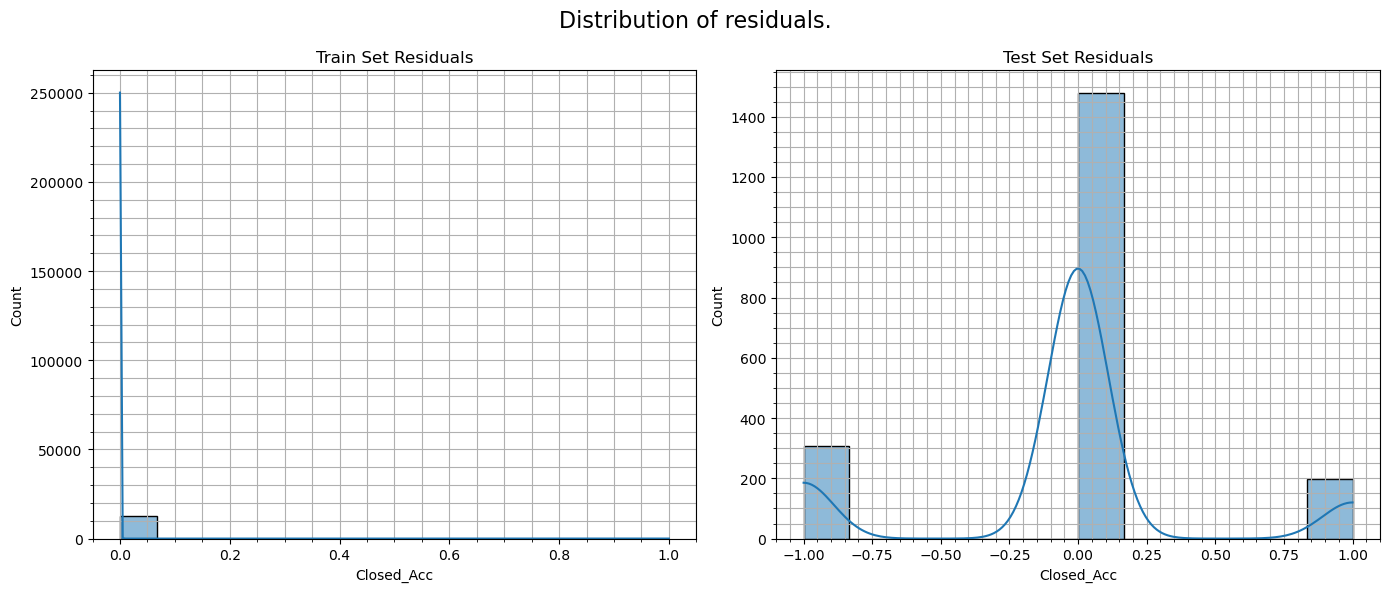

In [18]:
train_residuals = y_train - y_train_pred
test_residuals = y_test - y_test_pred

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
sns.histplot(train_residuals, kde=True)
plt.title("Train Set Residuals")
plt.minorticks_on()
plt.grid(which='both')

plt.subplot(1, 2, 2)
sns.histplot(test_residuals, kde=True)
plt.title("Test Set Residuals")
plt.minorticks_on()
plt.grid(which='both')


plt.suptitle('Distribution of residuals.', fontsize=16)
plt.tight_layout()
plt.show()

In [19]:
y_prob = best_knn.predict_proba(X_test)[:, 1]

threshold = 0.65
y_pred_custom_threshold = (y_prob >= threshold).astype(int)
conf_matrix = confusion_matrix(y_test, y_pred_custom_threshold)
print("Confusion Matrix:\n", conf_matrix)

Confusion Matrix:
 [[1285  291]
 [ 195  213]]


In [20]:
y_test_pred = y_pred_custom_threshold

In [21]:
accuracy = accuracy_score(y_test, y_test_pred)
auc = roc_auc_score(y_test, y_prob)
# Tablular format for accuracy and AUC.
metrics = {
    'Metric': ['Accuracy', 'ROC-AUC'],
    'Score': [accuracy, auc]
}
metrics_df = pd.DataFrame(metrics)

print("Other Metrics:")
display(metrics_df)

Other Metrics:


,Metric,Score
0,Accuracy,0.755040
1,ROC-AUC,0.733701


In [22]:
y_test_prob = best_knn.predict_proba(X_test_scaled)
cm = confusion_matrix(y_test, y_test_pred)

# Converting the confusion matrix to DataFrame.
cm_df = pd.DataFrame(cm, index=['True', 'False'], columns=['Positive', 'Negative'])

print("Confusion Matrix:")
display(cm_df)

Confusion Matrix:


,Positive,Negative
True,1285,291
False,195,213


In [23]:
report = classification_report(y_test, y_test_pred, output_dict=True)
# Converting the classification report (which is a dictionary) to DataFrame and transposing for better readability.
report_df = pd.DataFrame(report).T

print("Classification Report:")
display(report_df)

Classification Report:


,precision,recall,f1-score,support
0,0.868243,0.815355,0.840969,1576.00000
1,0.422619,0.522059,0.467105,408.00000
accuracy,0.755040,0.755040,0.755040,0.75504
macro avg,0.645431,0.668707,0.654037,1984.00000
weighted avg,0.776603,0.755040,0.764085,1984.00000


In [24]:
accuracy = accuracy_score(y_test, y_test_pred)
auc = roc_auc_score(y_test, y_test_prob[:, 1])
# Tablular format for accuracy and AUC.
metrics = {
    'Metric': ['Accuracy', 'ROC-AUC'],
    'Score': [accuracy, auc]
}
metrics_df = pd.DataFrame(metrics)

print("Other Metrics:")
display(metrics_df)

Other Metrics:


,Metric,Score
0,Accuracy,0.755040
1,ROC-AUC,0.722346


In [25]:
submission_dataframe = pd.DataFrame({
    'index': X_test.index,
    'Closed_Acc': y_test_pred
})
submission_dataframe.head(2)

,index,Closed_Acc
0,2305,1
1,8325,0


In [26]:
submission_dataframe_file = ('../d. Output Files/BankChurn/' + 'BankChurn_Prediction.csv')
print(f"File name: {submission_dataframe_file.split('/')[3]}")
submission_dataframe.sort_values(by='index', inplace=True)
submission_dataframe.to_csv(submission_dataframe_file, index=False)

File name: BankChurn_Prediction.csv
